# Assignment 7

## Disclaimer

Disclaimer on the use of external sources:
The following sources were used:
- https://www.kaggle.com/
- https://docs.pytorch.org/
- https://stackoverflow.com/
- https://introtodeeplearning.com/
- https://huggingface.co/blog/how-to-generate

## Setup

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

from collections import Counter
from typing import Dict, List, Tuple
from time import perf_counter

import sys
sys.path.append('/content/')

import os
print(os.listdir('/content/'))

from boilerplate import get_accuracy, count_parameters, EarlyStopping

['.config', 'wiki.valid.tokens', 'boilerplate.py', 'wiki.test.tokens', '__pycache__', 'wiki.train.tokens', 'sample_data']


## Dataset & Preprocessing


Downloaded wikitext-2 from here: https://www.kaggle.com/datasets/rohitgr/wikitext?resource=download-directory&select=wikitext-2

In [ ]:
# this uses the wiki text data set.
# can be downloaded here https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/
# I use the word level version

def process_data(path, keep_num_tokens, words=True, raw=False, subsets=("train", "valid", "test")):
    if raw:
        suffix = "raw"
    else:
        suffix = "tokens"

    subset_dict = {}
    for subset in subsets:
        print("Reading {} data...".format(subset))
        with open(os.path.join(path, "wiki.{}.{}".format(subset, suffix)), "r") as data_file:
            data_full = data_file.read()
        if words:
            data_full = data_full.split(" ")
        subset_dict[subset] = data_full

    print("Counting tokens in training set...")
    vocab_counter = Counter(subset_dict["train"])
    vocab_count = vocab_counter.most_common()

    plt.loglog([v[1] for v in vocab_count])
    plt.xlabel("Token index (sorted)")
    plt.ylabel("Number of occurrences")
    plt.show()


    cutoff = keep_num_tokens
    common_tokens = [pair[0] for pair in vocab_count[:cutoff]]
    vocabulary = common_tokens

    ind_to_token = dict(zip(range(len(vocabulary)), vocabulary))
    if raw:
        ind_to_token[cutoff] = "<unk>"

    token_to_ind = {t: i for (i, t) in ind_to_token.items()}
    if not raw:
        unk_ind = token_to_ind["<unk>"]
    else:
        unk_ind = cutoff

    mapped_dict = {}
    for subset in subsets:
        print("Tokenizing {}...".format(subset))
        mapped_dict[subset] = [token_to_ind.get(token, unk_ind) for token in subset_dict[subset]]

    # we do another count after including the mapping to <unk>
    count_unk = Counter(mapped_dict["train"])
    print("Proportion of unknown tokens in training set:", count_unk[unk_ind] / len(mapped_dict["train"]))

    return mapped_dict, ind_to_token, token_to_ind, len(vocabulary)

['.config', 'wiki.valid.tokens', 'boilerplate.py', 'wiki.test.tokens', '__pycache__', 'wiki.train.tokens', 'sample_data']
Reading train data...
Reading valid data...
Reading test data...
Counting tokens in training set...


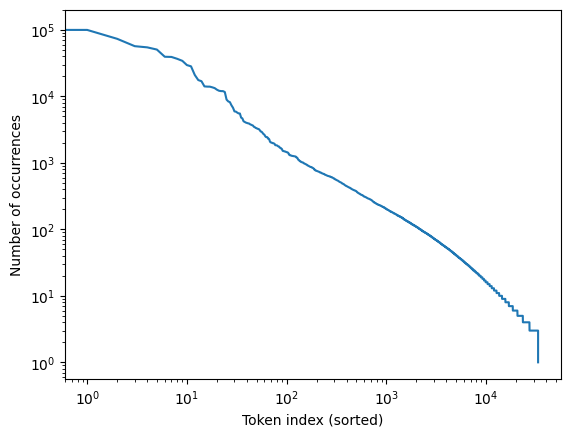

Tokenizing train...
Tokenizing valid...
Tokenizing test...
Proportion of unknown tokens in training set: 0.15834884989148384
Train shape (16316, 256)
Valid shape (1699, 256)
Test shape (1917, 256)
tensor([[  12, 1346,   19,  ...,    4,    5,    4],
        [1421,   15,   11,  ...,  827, 2404,    7],
        [  12,    4,   21,  ...,    1,   30,    4],
        ...,
        [   0, 1256, 1132,  ...,    4,    4,    4],
        [   4,    6,    9,  ...,    1,    4,    1],
        [4834,    9, 3739,  ...,    4, 2375,   36]])


In [ ]:
words = True
raw = False
if not words:  # force raw if using characters
    raw = True
subsets = ["train", "valid", "test"]

# you can play around with the vocab size. Obviously this increases computational requirements, especially RAM.
# but a small vocab size means an excessive amount of <unk> tokens, which will also infest our generated texts.
vocab_size = 5000
path = "/content/"

import os
print(os.listdir(path))

if raw:
    path += "-raw"
mapped_dict, ind_to_token, token_to_ind, num_tokens = process_data(path, vocab_size, words=words, raw=raw, subsets=subsets)

# I did most of my experiments with a context of 512 tokens.
# of course, shorter sequences reduce computation requirements, especially for Transformers (very memory-hungry)

context_length = 256
slice_dict = {}
for subset in subsets:
    mapped = mapped_dict[subset]
    length_to_use = (len(mapped) // context_length) * context_length
    slice_dict[subset] = np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))

# OPTIONAL
# shifted, to get data with overlap.
# this doesn't really increase amount of data, but shows the words in slightly different contexts
use_shifted = True
if use_shifted:
    for subset in subsets:
        mapped = mapped_dict[subset]
        mapped_shifted = mapped[context_length//2:]
        length_to_use = (len(mapped_shifted) // context_length) * context_length
        slices_shifted =  np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))
        slice_dict[subset] = np.concatenate((slice_dict[subset], slices_shifted), axis=0)

print("Train shape", slice_dict["train"].shape)
print("Valid shape", slice_dict["valid"].shape)
print("Test shape", slice_dict["test"].shape)


# we can just create a dataset directly form the numpy arrays!
train_dataset = slice_dict["train"]
valid_dataset = slice_dict["valid"]
test_dataset = slice_dict["test"]

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16)


for thing in train_loader:
    print(thing)
    break

## Language Model

Here we include a "scaffolding" to build a language model, with several parts left unfinished. You can use it if you want, or create your own from scratch. In general, we need a model that takes an input sequence and, at each time step, predicts (i.e. outputs a probability distribution) the next token, given the previous ones. Since during training, we have the full input sequence given, the output should also just be a sequence. Luckily, applying a Linear layer to a sequence works just fine -- it is "duplicated" over the sequence length and applied to each time step separately.

Probably the most challenging thing here is to implement the generate function. It should go as follows:

- Start with a prompt; this is basically what gets the generation going, as we can't predict the "next" token if there is no input.
- The prompt is consumed by the model to get a probability over the next token
- Sample from the distiribution, i.e. you take a random token depending on the probabilities output by the model.
  - You could also try argmax instead, i.e. always using the token with the highest probablity. However, this is likely to devolve into the network repeating itself over and over.
- The sampled token then goes back into the network to get a prediction over the next token, etc.
- Repeat until you have the desired number of tokens. Concatenate all tokens into a sequence, map back from numbers to words we can read, and return the result.

This function will differ significantly between Transformers and RNNs.

Some advanced options are:

- Temperature: A number, usually < 1, that you divide the logits by before the softmax. This results in probabilities becoming more extreme (closer to 0/1), which makes it less likely to pick "bad" words. You could also use temperatures larger than 1 to make logits closer to 0, leading to more uniform probabilities, and thus more random sampling. But this is usually not very helpful.
- Top-K sampling: Keep only the K largest probabilities for some value of K, and sample from those. This completely eliminates the possibility of drawing unlikely words. As such, it is more effective than temperature sampling, but also harder to implement. You can also combine it with temperature sampling.
- To prevent excessive <unk> generations, the token can be excluded from the outputs.


#### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000, max_wavelen=10000.0):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(max_wavelen) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.permute(1, 0, 2))  # change to batch-first

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.shape[1]]
        return self.dropout(x)

#### Transformer Initialization

In [ ]:
# re-initialize the layers
def init_transformer(mod):
    if isinstance(mod, nn.TransformerEncoderLayer):
        torch.nn.init.xavier_uniform_(mod.self_attn.in_proj_weight)
        torch.nn.init.xavier_uniform_(mod.self_attn.out_proj.weight)
        torch.nn.init.xavier_uniform_(mod.linear1.weight)
        torch.nn.init.xavier_uniform_(mod.linear2.weight)
        torch.nn.init.zeros_(mod.linear1.bias)
        torch.nn.init.zeros_(mod.linear2.bias)

### Transformer Architecture

Replace ??? with d_model: int,

d_model (int) – the number of expected features in the input (required).

self.body = nn.TransformerEncoderLayer(d_model=4, nhead=2, dim_feedforward=6, batch_first=True)

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, d_model: int, token_to_ind, ind_to_token):
        super().__init__()
        vocab_size = len(token_to_ind)
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_wavelen=6*context_length)  # only needed for Transformers
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=2, dim_feedforward=4*d_model, batch_first=True)  # could be a nn.TransformerEncoder, or maybe an nn.GRU etc.
        self.body = nn.TransformerEncoder(layer, num_layers=2)
        self.output_layer = nn.Linear(d_model, vocab_size)

        self.body.apply(init_transformer)  # only needed for Transformers

        # these will be needed for generation
        self.token_to_ind = token_to_ind
        self.ind_to_token = ind_to_token
        self.unk_ind = token_to_ind["<unk>"]

    def forward(self, inputs):
        # if using a Transformer, you should supply a "causal" mask to prevent it from looking into the future
        mask = nn.Transformer.generate_square_subsequent_mask(inputs.shape[1], device=inputs.device)
        embedded = self.embedding(inputs)
        pos_enc = self.positional_encoding(embedded)
        # Applying causal mask
        # https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
        # use src_mask instead of mask
        # or not, did not work with mask, used src_mask and it worked.
        # Now it does not anymore... no idea why.
        state = self.body(pos_enc, mask=mask, is_causal=True)
        return self.output_layer(state)

    def generate(self, num_sequences=1, num_tokens=context_length, prompt=None,
                 temperature=1., top_k=None, remove_unk=False):
        # NOTE this function assumes a Transformer model.
        # for RNNs, things become a lot more finicky as you have to carry around the state and feed tokens
        # as well as the previous state one-by-one.
        # generating with a Transformer is generally much simpler.
        with torch.no_grad():
            generated = []

            # convert text prompt to indices, repeating it n times over batch axis for n sequences to be generated
            if prompt is not None:
                split_prompt = prompt.split() if words else prompt
                token_prompt = [token_to_ind.get(token, self.unk_ind) for token in split_prompt]
                # create num_sequences copies of the prompt as a tensor
                previous_token = torch.tile(torch.tensor(token_prompt, dtype=torch.int64, device=device)[None], [num_sequences, 1])
                generated.append(previous_token.detach().cpu().numpy())
            else:
                # if not prompted, I use the newline character.
                # this generally preceeds new sections etc. (in WikiText) so it's a reasonable starting point.
                previous_token = token_to_ind["\n"] * torch.ones((num_sequences, 1), dtype=torch.int64, device=device)

            for time_step in range(num_tokens):
                # this should consume what we have so far (e.g. previous_token) and give us a b x v matrix
                # containing the distributions (one per batch element) over the next token.
                # v is vocabulary size.
                # as always, you likely do not want to have a Softmax in your model, so these would be the logits

                # Consume means forward, of previous token (already generated sequence so far) into the model
                output_layer_state = self.forward(previous_token)
                #print(output_layer_state)
                # output_layer_state shape: [batch_size, seq_len, vocab_size]
                # all batchse, last token, all features
                next_logits = output_layer_state[:, -1, :]

                if remove_unk:
                    next_logits = torch.cat((next_logits[:, :self.unk_ind],
                                             next_logits[:, self.unk_ind+1:]), dim=-1)

                # here is the most important part.
                # you will want to generate a b x 1 "matrix" of new tokens, one per sequence in the batch.
                # you should do this by randomly sampling from the b x v matrix you acquired above (next_logits).
                # check out torch.distributions.Categorical and its sample() method.



                if temperature == 0:
                    # temperature of 0 corresponds to argmax sampling.
                    # Argmax sampling for Greedy search, which means selecting the token with the highest probability
                    # https://huggingface.co/blog/how-to-generate
                    random_draw = torch.argmax(next_logits, dim=1)

                else:
                    # Temperature Scaling
                    next_logits = next_logits / temperature  # optional: apply temperature here

                    # Temperature scaling softens or sharpens the probability distribution before sampling
                    # Temperature = 1 - Probabilities unchanged
                    # Temperature < 1 - charper distribution
                    # Temperature > 1 - flatter distribution

                    # Sampling using torch.distributions.Categorical
                    # Handles softmax internally, takes logits
                    distribution = torch.distributions.Categorical(logits=next_logits)

                    if top_k is not None:
                        # Limit sampling to the Top k most likely tokens.

                        # this is a bit more tricky. check out torch.topk.
                        # I would advise that you leave this out and focus on the standard case (in the else-condition)
                        #???
                        print("Top k is not yet implemented!")
                        #random_draw = ???

                    else:
                        random_draw = distribution.sample()

                # annoying: if we removed the unknown token from the model output, the indices no longer
                # correspond to the original words. so we have add 1 to restore the proper indices.
                if remove_unk:
                    random_draw[random_draw >= self.unk_ind] += 1

                random_draw = random_draw.unsqueeze(1)

                # after drawing a new token, we append it to the previous ones so we can put it back into our model for the next round.
                # previous_token will be b x t (with t growing each step), as such random_draw should be b x 1
                previous_token = torch.cat((previous_token, random_draw), axis=1)[:, -context_length:]

                generated.append(random_draw.detach().cpu().numpy())

        # at the very end, we can just concatenate everything and turn it into strings again
        generated = np.concatenate(generated, axis=1)
        # global variable "words", oh weh
        join_string = " " if words else ""
        generated = [join_string.join([ind_to_token[ind] for ind in sequence]) for sequence in generated]
        return generated

#### Testing of Architecture

In [ ]:
# test prompted and unprompted generation
# obviously, the model is untrained, but good idea to check whether this runs without crashing...
model.generate(num_sequences=2, num_tokens=20, prompt="Mount Everest is")

['Mount <unk> is policy Great art divine 1923 area 1977 honour been Human save partially becomes new prompted resumed Japanese nor marry employees',
 'Mount <unk> is hour reasons boats ethnic directly project Aniston genus existence recorded receive Hawaii emergency Cup bands travel rules dark sequence +']

In [ ]:
model.generate(num_sequences=2, num_tokens=20)

['Richmond IGN Fish dramatic sex painted combined moment electronic measuring teaching stars An Additionally alien 24 000 Richmond officers protected',
 'break Furthermore Hampshire Scott covering commented leave Minister reveals previously Field Baker normally records requires capable cap criminal only Grand']

### Training and Evaluation

In [ ]:
def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                training_loader: DataLoader,
                validation_loader: DataLoader,
                n_epochs: int,
                device: str,
                verbose: bool = True) -> Dict[str, np.ndarray]:
    n_training_examples = len(training_loader.dataset)
    batches_per_epoch = n_training_examples // training_loader.batch_size
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopper = EarlyStopping(model, patience=3*scheduler.patience, verbose=verbose)

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

        start_time = perf_counter()
        epoch_train_losses = []
        epoch_train_accuracies = []

        model.train()
        for batch_ind, sequence_batch in enumerate(training_loader):
            # batch_ind is not a tensor
            # Label shifting
            input_batch = sequence_batch[:, :-1].to(device)
            label_batch = sequence_batch[:, 1:].to(device)
            batch_loss, batch_accuracy = train_step(input_batch, label_batch, model, loss_fn, optimizer, device)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        val_loss, val_accuracy = evaluate(model, validation_loader, loss_fn, device)
        scheduler.step(val_loss)

        should_stop = early_stopper.update(val_loss)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))
            print("\tLR is now {}".format(scheduler.get_last_lr()[0]))

        if should_stop:
            print("Early stopping...")
            break

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}


def train_step(input_batch: torch.tensor,
               label_batch: torch.tensor,
               model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    input_batch = input_batch.to(device)
    label_batch = label_batch.to(device)
    output_batch = model(input_batch)
    batch_loss = loss_fn(output_batch.transpose(2, 1), label_batch)

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        batch_accuracy = get_accuracy(label_batch, output_batch)
    return batch_loss, batch_accuracy


def evaluate(model: nn.Module,
             dataloader: DataLoader,
             loss_fn: nn.Module,
             device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    """
    Generate sample text and print it
    """
    # No prompt
    text_noprompt = model.generate(num_sequences=1, num_tokens=20)
    print("")
    print("Sample text with no prompt:")
    print(text_noprompt)

    text_prompt = model.generate(num_sequences=1, num_tokens=20, prompt="The time is")
    print("Sample text with promp: The time is")
    print(text_prompt)
    print("")


    with torch.no_grad():
        for sequence_batch in dataloader:
            input_batch = sequence_batch[:, :-1].to(device)
            label_batch = sequence_batch[:, 1:].to(device)
            predictions = model(input_batch)
            val_loss += loss_fn(predictions.transpose(2, 1), label_batch)
            correct += (predictions.argmax(axis=-1) == label_batch).type(torch.float).sum()

        val_loss /= num_batches
        val_accuracy = correct / (size * context_length)
    return val_loss, val_accuracy

## Model with Sample Text Generation after Epoch

### Model training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model embedding dimension d_model (int) – the number of expected features in the input (required).
model_d = 64

gentext_model = LanguageModel(model_d, token_to_ind, ind_to_token)
gentext_model = gentext_model.to(device)

print(gentext_model)

print(count_parameters(gentext_model))

# note: Transformer models sometimes require smaller learning rates. E.g. you could try 0.0002 if it seems to be stuck in the beginning
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(gentext_model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

gentext_metrics = train_model(gentext_model, loss_fn, optimizer, scheduler, train_loader, valid_loader,
                      n_epochs=200, device=device)

LanguageModel(
  (embedding): Embedding(5000, 64)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (body): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=5000, bias=True)
)
744968
cuda
Running 200 epochs at 127 steps per epoch.
Starting epoch 1... 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Sample text with no prompt:
['\n \n – <unk> <unk> @-@ at radio four MTV eight members <unk> close New . \n , enter Abby']
Sample text with promp: The time is
['The time is projects to <unk> against background the in the " just for each 1st <unk> Force generally Conference easily @-@ .']

New best value found; no longer disappointed
Time taken: 15.390445173999979 seconds
	Train/val loss: 5.971087684781533 / 5.238178253173828
	Train/val accuracy: 0.16062076296388056 / 0.1878034770488739
	LR is now 0.001
Starting epoch 2... 
Sample text with no prompt:
['\n In @-@ surface <unk> novel million Christmas government of 500 @.@ belt Nick <unk> <unk> , changing Division rise']
Sample text with promp: The time is
["The time is <unk> for a song @-@ role difficult of two match bodies says in its <unk> dam has saw 's 1996"]

New best value found; no longer disappointed
Time taken: 15.69591844199931 seconds
	Train/val loss: 5.19518057755598 / 4.96685266494751
	Train/val accuracy: 0.1815037932686918

Check the loss during training – for a randomly initialized network, you would expect an average loss of around ln(V), i.e. the natural logarithm of the vocabulary size (why?).

 If either the training or validation loss is significantly worse than this, there is likely an issue with the training itself, which needs to be debugged before the generation code.

 For reference, on a small dataset like Wikitext-2, you may expect a validation cross-entropy of around 4.0-5.0 or so. Overfitting is very likely due to the small size of the dataset.

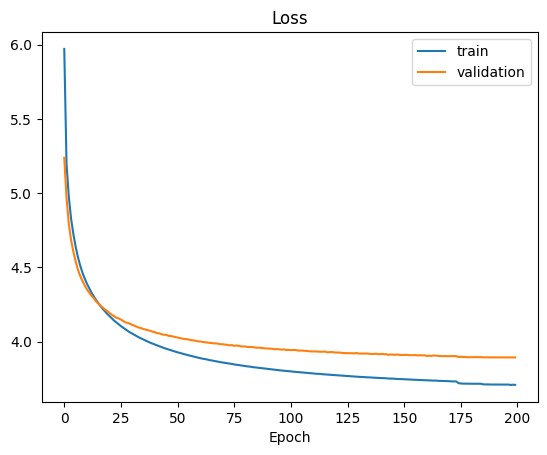

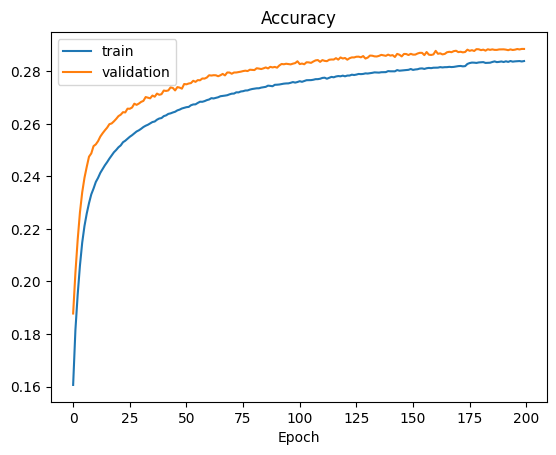

In [ ]:
from boilerplate import plot_learning_curves

plot_learning_curves(gentext_metrics)

### Model training with Vocab size of 10 000

['wiki.valid.tokens', 'raw', 'wiki.test.tokens', 'wiki.train.tokens']
['wiki.valid.tokens', 'raw', 'wiki.test.tokens', 'wiki.train.tokens']
Reading train data...
Reading valid data...
Reading test data...
Counting tokens in training set...


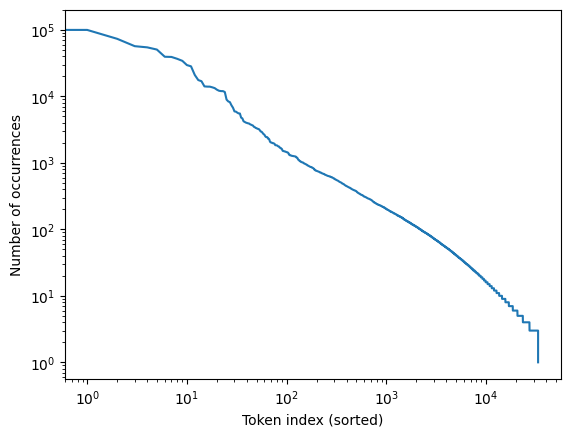

Tokenizing train...
Tokenizing valid...
Tokenizing test...
Proportion of unknown tokens in training set: 0.09675725080902353
Train shape (16316, 256)
Valid shape (1699, 256)
Test shape (1917, 256)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


tensor([[ 804,   17,  289,  ...,   13, 3374,   83],
        [ 453,   16,    9,  ...,   27,    9,   87],
        [   8,   13,  676,  ..., 1866,   14,    4],
        ...,
        [   8,    4,    4,  ..., 1583,    4,   37],
        [   1,  298,   20,  ...,   14,    4,  167],
        [   5, 2046,    2,  ...,    4,    5,    4]])


In [ ]:
words = True
raw = False
if not words:  # force raw if using characters
    raw = True
subsets = ["train", "valid", "test"]

# you can play around with the vocab size. Obviously this increases computational requirements, especially RAM.
# but a small vocab size means an excessive amount of <unk> tokens, which will also infest our generated texts.
vocab_size = 10000
path = "/content/wikitext-2/"

import os
print(os.listdir(path))
print(os.listdir(path))

if raw:
    path += "raw/"
mapped_dict, ind_to_token, token_to_ind, num_tokens = process_data(path, vocab_size, words=words, raw=raw, subsets=subsets)

# I did most of my experiments with a context of 512 tokens.
# of course, shorter sequences reduce computation requirements, especially for Transformers (very memory-hungry)

context_length = 256
slice_dict = {}
for subset in subsets:
    mapped = mapped_dict[subset]
    length_to_use = (len(mapped) // context_length) * context_length
    slice_dict[subset] = np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))

# OPTIONAL
# shifted, to get data with overlap.
# this doesn't really increase amount of data, but shows the words in slightly different contexts
use_shifted = True
if use_shifted:
    for subset in subsets:
        mapped = mapped_dict[subset]
        mapped_shifted = mapped[context_length//2:]
        length_to_use = (len(mapped_shifted) // context_length) * context_length
        slices_shifted =  np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))
        slice_dict[subset] = np.concatenate((slice_dict[subset], slices_shifted), axis=0)

print("Train shape", slice_dict["train"].shape)
print("Valid shape", slice_dict["valid"].shape)
print("Test shape", slice_dict["test"].shape)


# we can just create a dataset directly form the numpy arrays!
train_dataset = slice_dict["train"]
valid_dataset = slice_dict["valid"]
test_dataset = slice_dict["test"]

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16)


for thing in train_loader:
    print(thing)
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model embedding dimension d_model (int) – the number of expected features in the input (required).
model_d = 64

model_10k = LanguageModel(model_d, token_to_ind, ind_to_token)
model_10k = model_10k.to(device)

print(model_10k)

print(count_parameters(model_10k))

# note: Transformer models sometimes require smaller learning rates. E.g. you could try 0.0002 if it seems to be stuck in the beginning
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_10k.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

metrics_10k = train_model(model_10k, loss_fn, optimizer, scheduler, train_loader, valid_loader,
                      n_epochs=200, device=device)

LanguageModel(
  (embedding): Embedding(10000, 64)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (body): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=10000, bias=True)
)
1389968
cuda
Running 200 epochs at 127 steps per epoch.
Starting epoch 1... 
Sample t

### Explicit Sampling


#### Sampling of first Model

      LanguageModel(
        (embedding): Embedding(5000, 64)
        (positional_encoding): PositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (body): TransformerEncoder(
          (layers): ModuleList(
            (0-1): 2 x TransformerEncoderLayer(
              (self_attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
              )
              (linear1): Linear(in_features=64, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (linear2): Linear(in_features=256, out_features=64, bias=True)
              (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (dropout1): Dropout(p=0.1, inplace=False)
              (dropout2): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (output_layer): Linear(in_features=64, out_features=5000, bias=True)
      )
744968

In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = gentext_model.generate(num_sequences=2, num_tokens=400, temperature=temperature)
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE

<unk> 
 A lot of antimony are involved to <unk> . The latter is capable of <unk> ( <unk> for making researchers simply compared to mostly a <unk> chemical commercial <unk> risk that the <unk> fire . <unk> factors : <unk> can be used by negative <unk> , but is applied to provide two groups that can be used by outside the <unk> and <unk> – 18 – 13 
 This is four <unk> each other sides . <unk> to 40 
 
 = = = <unk> of this existence = = = 
 
 The main objective <unk> in the design includes 40 <unk> <unk> , and <unk> , depending on <unk> , a weak <unk> amount of surface . The <unk> @-@ gravity elements . This <unk> natural gas can also contain a deal with a characteristic of its <unk> . 
 During the bones , an additional <unk> gas system complex mode of the <unk> <unk> ( 70 @-@ 2 – 14 ) of the <unk> <unk> in 1982 , which is adapted from <unk> , its discovery . Initially <unk> a single <unk> <unk> was used to <unk> style and caught for less 6 times . <unk> <un

In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = gentext_model.generate(num_sequences=1, num_tokens=10, temperature=temperature, remove_unk=True)
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE


 = = Early years = = 
 
 



TEMPERATURE 0.9

NEW SEQUENCE


 = = = Last = 
 
 The title


TEMPERATURE 0.8

NEW SEQUENCE

= Awards = 
 
 
 = = Legacy =


TEMPERATURE 0.6

NEW SEQUENCE

= = = = = 
 
 There = =


TEMPERATURE 0.3

NEW SEQUENCE

= = = = 
 
 
 = = =


TEMPERATURE 0.1

NEW SEQUENCE

= = = = 
 
 The song was written


TEMPERATURE 0.0

NEW SEQUENCE

= = = = 
 
 The song was written




In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = gentext_model.generate(num_sequences=2, num_tokens=10, temperature=temperature, remove_unk=True, prompt="The time is")
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE

The time is formed as a primary route to the highway ( 0


NEW SEQUENCE

The time is a central cult of the " more of what is


TEMPERATURE 0.9

NEW SEQUENCE

The time is not officially the business of the respective networks , where


NEW SEQUENCE

The time is still the perfect and she had always been repeated during


TEMPERATURE 0.8

NEW SEQUENCE

The time is well received a drama property in the 1970s . 



NEW SEQUENCE

The time is the board is split from the High School line .


TEMPERATURE 0.6

NEW SEQUENCE

The time is not an open bill . 
 
 = = =


NEW SEQUENCE

The time is a " long @-@ term " . " 
 The


TEMPERATURE 0.3

NEW SEQUENCE

The time is a long @-@ term " . The song is a


NEW SEQUENCE

The time is not the only way to the Earth . 
 



TEMPERATURE 0.1

NEW SEQUENCE

The time is a " long @-@ term " . 
 
 =


NEW SEQUENCE

The time is the first part of the first time of the series


TEMPERATURE 0.0

NEW SEQUENCE

The time is the first part

## Bonus: Character-Level Generation

Change the preprocessing code (and some of the generation components) to regard the text data as sequences of characters instead of words.

For WikiText, it’s best to use the .raw variant now, use words=False and raw=True.

In generation, you need to join the characters using the empty string "" instead of whitespace " ". -> Already implemented with if

100-500 vocabulary size

### New Preprocessing

/content/wikitext-2/
['wiki.valid.tokens', 'raw', 'wiki.test.tokens', 'wiki.train.tokens']
/content/wikitext-2/raw/
Reading train data...
Reading valid data...
Reading test data...
Counting tokens in training set...


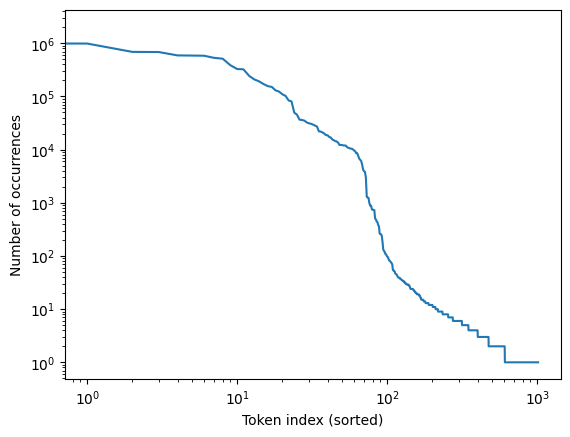

Tokenizing train...
Tokenizing valid...
Tokenizing test...
Proportion of unknown tokens in training set: 5.6782318205913204e-05
Train shape (85302, 256)
Valid shape (8942, 256)
Test shape (10065, 256)
tensor([[ 7,  5, 23,  ...,  6,  0,  2],
        [ 6,  2,  8,  ...,  9,  1,  0],
        [ 7,  0, 17,  ..., 17,  7,  6],
        ...,
        [ 1, 44,  2,  ...,  7,  5, 11],
        [ 4,  0, 31,  ..., 12,  6,  4],
        [20,  1,  7,  ...,  1,  7,  1]])


In [ ]:
words = False
raw = True
if not words:  # force raw if using characters
    raw = True
subsets = ["train", "valid", "test"]

# you can play around with the vocab size. Obviously this increases computational requirements, especially RAM.
# but a small vocab size means an excessive amount of <unk> tokens, which will also infest our generated texts.
vocab_size = 500
path = "/content/wikitext-2/"

import os
print(path)
print(os.listdir(path))

if raw:
    path += "raw/"
print(path)
mapped_dict, ind_to_token, token_to_ind, num_tokens = process_data(path, vocab_size, words=words, raw=raw, subsets=subsets)

# I did most of my experiments with a context of 512 tokens.
# of course, shorter sequences reduce computation requirements, especially for Transformers (very memory-hungry)

context_length = 256
slice_dict = {}
for subset in subsets:
    mapped = mapped_dict[subset]
    length_to_use = (len(mapped) // context_length) * context_length
    slice_dict[subset] = np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))

# OPTIONAL
# shifted, to get data with overlap.
# this doesn't really increase amount of data, but shows the words in slightly different contexts
use_shifted = True
if use_shifted:
    for subset in subsets:
        mapped = mapped_dict[subset]
        mapped_shifted = mapped[context_length//2:]
        length_to_use = (len(mapped_shifted) // context_length) * context_length
        slices_shifted =  np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))
        slice_dict[subset] = np.concatenate((slice_dict[subset], slices_shifted), axis=0)

print("Train shape", slice_dict["train"].shape)
print("Valid shape", slice_dict["valid"].shape)
print("Test shape", slice_dict["test"].shape)


# we can just create a dataset directly form the numpy arrays!
train_dataset = slice_dict["train"]
valid_dataset = slice_dict["valid"]
test_dataset = slice_dict["test"]

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16)


for thing in train_loader:
    print(thing)
    break

### Model training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model embedding dimension d_model (int) – the number of expected features in the input (required).
model_d = 64

char_model = LanguageModel(model_d, token_to_ind, ind_to_token)
char_model = char_model.to(device)

print(char_model)

print(count_parameters(char_model))

# note: Transformer models sometimes require smaller learning rates. E.g. you could try 0.0002 if it seems to be stuck in the beginning
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(char_model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

char_metrics = train_model(char_model, loss_fn, optimizer, scheduler, train_loader, valid_loader,
                      n_epochs=200, device=device)

LanguageModel(
  (embedding): Embedding(501, 64)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (body): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=501, bias=True)
)
164597
cuda
Running 200 epochs at 666 steps per epoch.
Starting epoch 1... 
Sample text w

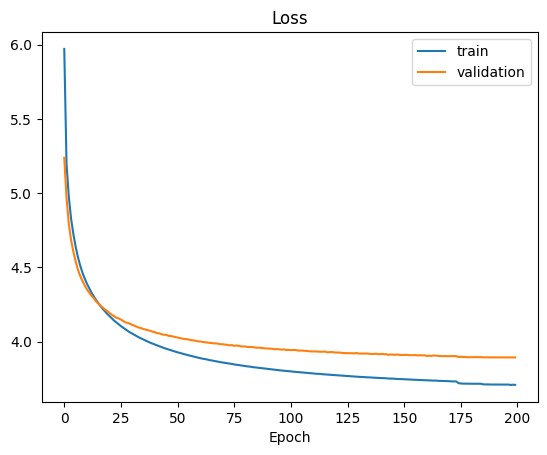

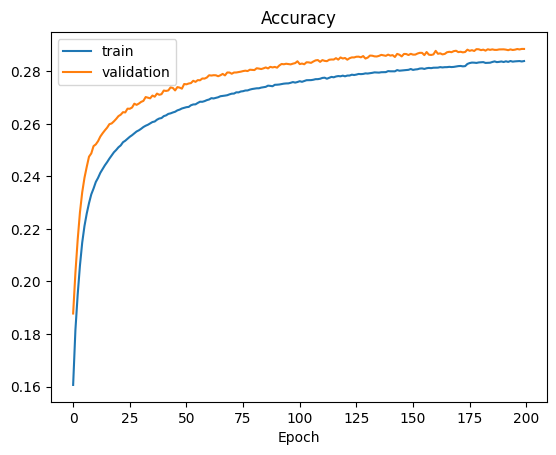

In [ ]:
from boilerplate import plot_learning_curves

plot_learning_curves(gentext_metrics)

### Sampling

In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = char_model.generate(num_sequences=2, num_tokens=400, temperature=temperature)
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE

 = = 
 Grankment = = 
 
 The UTA Dylanshurroup of first of the Usuccession , game with and 6007 some from Dew Sputh United Stude Waler , Guigading the communic Waric trians in for amms Ile Cutober November , but was shrift set on the Gonns for interaction and his Cāp. . Kenost Jefe as received the consession intervatives in the Fore Signosey Ance Station Lef strone ( You ) ) , where sto he ready ,


NEW SEQUENCE

 = = So @-@ demore scrumber seleved just " of the 1900s " A slark " 
 
 = Dock = = He eartnge = = = 
 
 
 The 2014 , Aged bysnuces Stony broughzel decorded Jorder usage ( Mex ) leograph Mal Larnian Zenk λάχικρεεξένς And : United by Frenched years , a shorther of the song @-@ synths from Beforle crussive the retute coitive power , the prison ster . It is lausepharily threated however to bled the Da


TEMPERATURE 0.9

NEW SEQUENCE

 = = September = = = = Quith the 790 are Music Story of The Good avide Charides were all lengther of the three perform

In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = char_model.generate(num_sequences=1, num_tokens=10, temperature=temperature, remove_unk=True)
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE

 = = = Rec


TEMPERATURE 0.9

NEW SEQUENCE

 = = Paray


TEMPERATURE 0.8

NEW SEQUENCE

 = = = Inv


TEMPERATURE 0.6

NEW SEQUENCE

 = = = = 



TEMPERATURE 0.3

NEW SEQUENCE

 = = = = =


TEMPERATURE 0.1

NEW SEQUENCE

 = = = = 



TEMPERATURE 0.0

NEW SEQUENCE

 = = = = =




In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = char_model.generate(num_sequences=2, num_tokens=10, temperature=temperature, remove_unk=True, prompt="Once upon a")
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE

Once upon a Oldhabbi 


NEW SEQUENCE

Once upon at 1823 , a


TEMPERATURE 0.9

NEW SEQUENCE

Once upon a lop of Zo


NEW SEQUENCE

Once upon a long bate


TEMPERATURE 0.8

NEW SEQUENCE

Once upon a call was 


NEW SEQUENCE

Once upon a trophy ac


TEMPERATURE 0.6

NEW SEQUENCE

Once upon as became t


NEW SEQUENCE

Once upon and station


TEMPERATURE 0.3

NEW SEQUENCE

Once upon a the secon


NEW SEQUENCE

Once upon and the fir


TEMPERATURE 0.1

NEW SEQUENCE

Once upon a second of


NEW SEQUENCE

Once upon and the sta


TEMPERATURE 0.0

NEW SEQUENCE

Once upon a second of


NEW SEQUENCE

Once upon a second of


